In [1]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import h5py

Initialize the Earth Engine client.

In [2]:
ee.Initialize()

Download and stack datasets from diferent Areas of Interest (AOIs)

In [44]:
# Central position of (AOIs)
points = [[-120.7224, 37.3872], [-112.6799, 42.9816]]

In [45]:
from Landsat_classifier_dataset import landsat_classifier_datasets

for n, point in enumerate(points):
    scd = landsat_classifier_datasets(point = point, buffer = 30000 , startDate = '2014', stopDate = '2017', scale = 30)
    dataset_x, dataset_y = scd.read_datasets()
    if n == 0:
        data_x = dataset_x
        data_y = dataset_y
    else:
        szy1, szx1 = data_x.shape[:2]
        szy2, szx2 = dataset_x.shape[:2]
        if szy1 != szy2 or szx1 != szx2:
            szy = min(szy1, szy2)
            szx = min(szx1, szx2)
            
            data_x = np.stack((data_x[:szy,:szx,:], dataset_x[:szy,:szx,:]), axis=0)
            data_y = np.stack((data_y[:szy,:szx,:], dataset_y[:szy,:szx,:]), axis=0)
        else:
            data_x = np.stack((data_x, dataset_x), axis=0)
            data_y = np.stack((data_y, dataset_y), axis=0)

url:  https://earthengine.googleapis.com/api/download?docid=6b2c6ef43461f358238e54b57a08fdd7&token=efaacf8f349128cb5a6b44a9b90afce6
Download complete!
url:  https://earthengine.googleapis.com/api/download?docid=72030485942c121d0ccfc43163dada1d&token=1013b14091e6532308bc57a9cf888688
Download complete!
url:  https://earthengine.googleapis.com/api/download?docid=d802cad3f9add31a5971eff45a3882c6&token=6a5650bcf5b535a293eac02176751bec
Download complete!
url:  https://earthengine.googleapis.com/api/download?docid=92845f0bdeb4136a93bc6d5e17f13d48&token=8f6ecd2c54d09b75715a7e95795e5d6b
Download complete!


**Display channels**

In [46]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

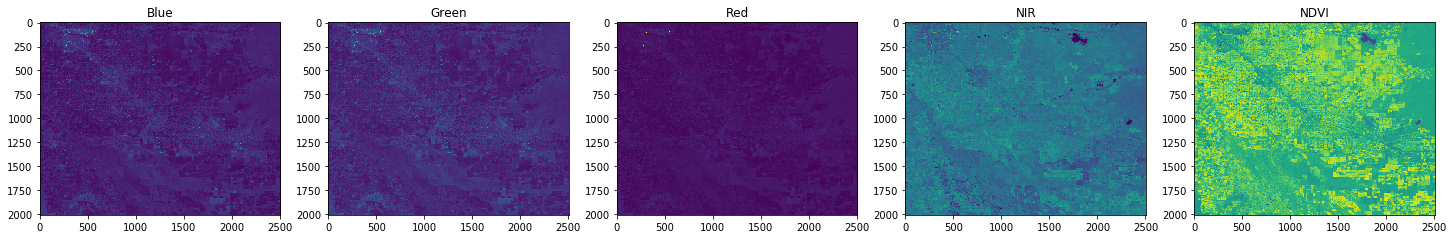

In [47]:
display_channels(data_x[0,:,:,:], data_x.shape[3], titles=['Blue', 'Green', 'Red', 'NIR', 'NDVI'])

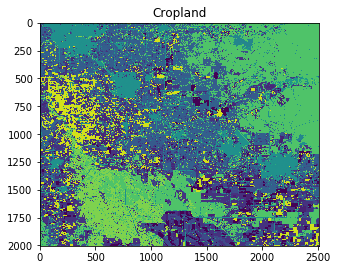

In [48]:
display_channels(data_y[0,:,:,:], data_y.shape[3], titles=['Cropland'])

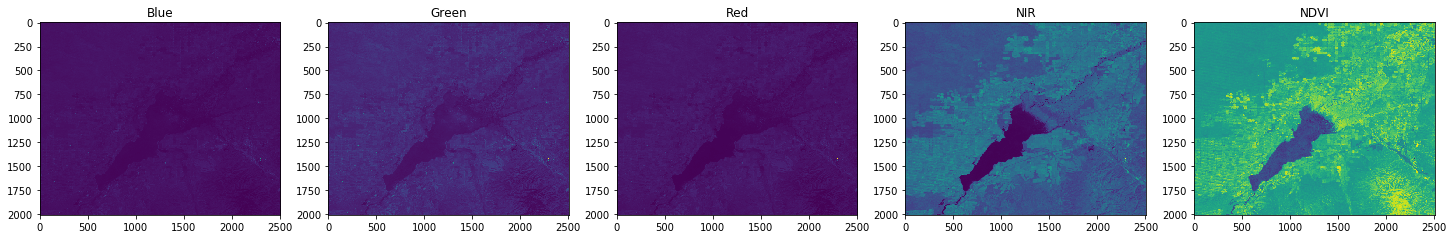

In [49]:
display_channels(data_x[1,:,:,:], data_x.shape[3], titles=['Blue', 'Green', 'Red', 'NIR', 'NDVI'])

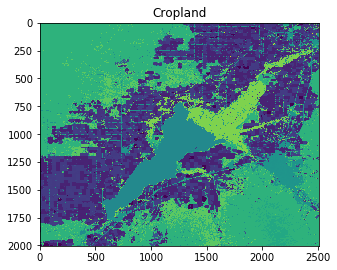

In [50]:
display_channels(data_y[1,:,:,:], data_y.shape[3], titles=['Cropland'])

**Preprocess class labels**

In [51]:
# Area of Interest (AoI)
geom = ee.Geometry.Point(-112.835, 43.015).buffer(10000)
# Start and stop of time series
startDate = ee.Date('2014')
stopDate  = ee.Date('2017')

In [52]:
dataset = ee.ImageCollection('USDA/NASS/CDL')\
    .filterBounds(geom)\
    .filterDate(startDate,stopDate)

In [53]:
cropland_info = pd.DataFrame({'cropland_class_values':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_values'),
                              'cropland_class_palette':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_palette'),
                              'cropland_class_names':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_names')
                             })
cropland_info.head()

,cropland_class_values,cropland_class_palette,cropland_class_names
0,0,000000,Background
1,1,ffd300,Corn
2,2,ff2626,Cotton
3,3,00a8e5,Rice
4,4,ff9e0c,Sorghum


The number of unique classes in this are is equal to:

In [54]:
len(np.unique(data_y[:,:,:,0]))

76

and the number of pixels by class

In [55]:
value, count = np.unique(data_y[0,:,:,0], return_counts=True)
df = pd.DataFrame({'cropland_class_values': value, 'cropland_class_counts': count})
df.sort_values(by='cropland_class_counts', ascending=False, inplace=True)
df = pd.merge(df, cropland_info, how='left', on=['cropland_class_values'])
df.head()

,cropland_class_values,cropland_class_counts,cropland_class_palette,cropland_class_names
0,176.0,1300787,e8ffbf,Grassland/Pasture
1,75.0,679906,00a582,Almonds
2,36.0,512896,ffa5e2,Alfalfa
3,195.0,333050,7fb2b2,Herbaceous Wetlands
4,69.0,314967,704489,Grapes


Create new classes:
- Land
- Water
- Urban
- Croplands

In [56]:
def replace_values(array, class_labels, new_label):
    array_new = np.copy(array)
    for i in range(len(class_labels)):
        array_new[np.where(array == class_labels[i])] = new_label
        
    return array_new

In [57]:
land = ['Shrubland', 'Barren', 'Grassland/Pasture', 'Deciduous Forest', 'Evergreen Forest', 'Mixed Forest', 'Wetlands', 'Woody Wetlands', 'Herbaceous Wetlands']
water = ['Water', 'Open Water', 'Aquaculture']
urban = ['Developed', 'Developed/Open Space', 'Developed/High Intensity', 'Developed/Low Intensity', 'Developed/Med Intensity']

In [58]:
class_labels_0 = np.array(cropland_info[cropland_info['cropland_class_names'].isin(land)]['cropland_class_values'])
class_labels_1 = np.array(cropland_info[cropland_info['cropland_class_names'].isin(water)]['cropland_class_values'])
class_labels_2 = np.array(cropland_info[cropland_info['cropland_class_names'].isin(urban)]['cropland_class_values'])
class_labels_3 = np.array(cropland_info[(~cropland_info['cropland_class_names'].isin(land)) & 
                                        (~cropland_info['cropland_class_names'].isin(water)) & 
                                        (~cropland_info['cropland_class_names'].isin(urban))]['cropland_class_values'])

In [59]:
# We replace the class labels
new_data_y = np.copy(data_y[:,:,:,0])
new_data_y = replace_values(new_data_y, class_labels_3, 3.)
new_data_y = replace_values(new_data_y, class_labels_2, 2.)
new_data_y = replace_values(new_data_y, class_labels_1, 1.)
new_data_y = replace_values(new_data_y, class_labels_0, 0.)

In [60]:
# Convert 1-dimensional class arrays to 3-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, 4)

In [61]:
data_y = new_data_y

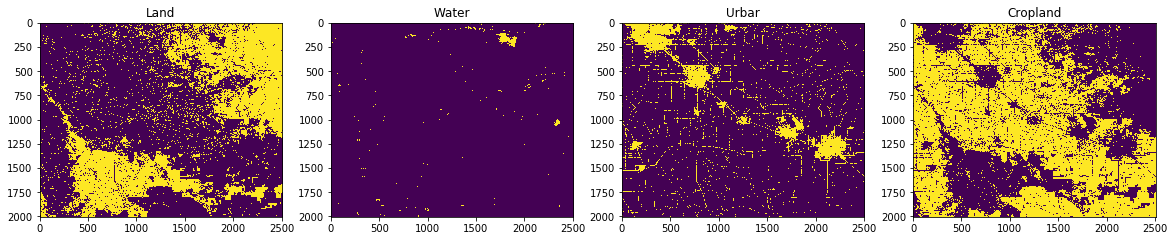

In [62]:
display_channels(new_data_y[0,:,:,:], new_data_y.shape[3], titles=['Land', 'Water', 'Urbar', 'Cropland'])

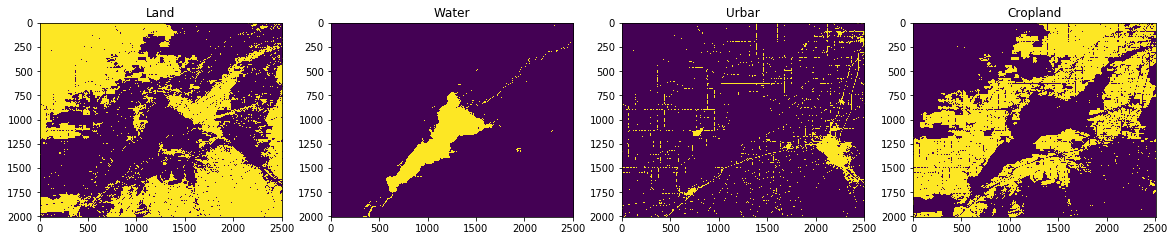

In [63]:
display_channels(new_data_y[1,:,:,:], new_data_y.shape[3], titles=['Land', 'Water', 'Urbar', 'Cropland'])

In [64]:
data_y = new_data_y

**Normalize data**

In [65]:
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data[:,:,:,i].max()
        mn = data[:,:,:,i].min()
        
        data[:,:,:,i] = (data[:,:,:,i]-mn)/(mx-mn)
    return data

In [66]:
data_x_norm = normalize_data(data_x)

In [67]:
data_x = data_x_norm

**Resize the images**

In [68]:
def reshape_data(data):
    size = data.shape
    new_size = []
    new_size.append(reduce(lambda x, y: x*y, size[:-1]))
    new_size.append(size[-1])
    new_size = tuple(new_size)
    return size, new_size

In [69]:
size_x, new_size_x = reshape_data(data_x)
size_y, new_size_y = reshape_data(data_y)

data_x_new = data_x.reshape(new_size_x)
data_y_new = data_y.reshape(new_size_y)

**Randomize the datasets**

In [70]:
def randomize_datasets(data_x, data_y):
    t=data_x.shape[0]
    arr_t = np.arange(t)
    np.random.shuffle(arr_t)
    data_x = data_x[arr_t,:]
    data_y = data_y[arr_t,:]
    
    return data_x, data_y

In [71]:
x_randm, y_randm = randomize_datasets(data_x_new, data_y_new)

**Training and validation sets**

In [72]:
def train_validation_split(x, y, val_size=20):
    t=x.shape[0]
    size = int(t*((100-val_size)/100))
    
    xt = x[:size,:]
    xv = x[size:,:]
    yt = y[:size,:]
    yv = y[size:,:]
    
    return xt, xv, yt, yv

In [73]:
x_train, x_validation, y_train, y_validation = train_validation_split(x_randm, y_randm)

## Define the Keras model

Here we define a neural network with two hidden layers with `relu` nonlinearities.

In [76]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

batch_size = 32
num_bands = 2
num_classes = 4
epochs = 1

model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(num_bands,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               1536      
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 2052      
Total params: 266,244
Trainable params: 266,244
Non-trainable params: 0
_________________________________________________________________


**Compile the model**

In [77]:
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

**Train the Neural Network**

In [78]:
from keras.callbacks import Callback, ModelCheckpoint

In [79]:
# To saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath="{0}_weights.hdf5".format('FCN'), verbose=1, save_best_only=True)

In [ ]:
model.fit(x_train[:,3:], y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_validation[:,3:], y_validation), callbacks=[checkpointer])

Train on 8035238 samples, validate on 2008810 samples
Epoch 1/1
7713248/8035238 [===========================>..] - ETA: 32s - loss: 0.7087 - acc: 0.7324

**Evaluate model**

In [85]:
score = model.evaluate(x_validation[:,3:], y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7080450500829344
Test accuracy: 0.7246832701946733


**Read the weights**

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

batch_size = 32
num_classes = 4
epochs = 1

model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(5,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.load_weights("{0}_weights.hdf5".format('FCN'))

## Predict

In [262]:
# Central position of (AOIs)
point = [-90.075, 35.985]
point = [-112.4336, 43.1682]

In [264]:
from Landsat_classifier_dataset import landsat_classifier_datasets

scd = landsat_classifier_datasets(point = point, buffer = 20000 , startDate = '2014', stopDate = '2017', scale = 30)
data_x, data_y = scd.read_datasets()

url:  https://earthengine.googleapis.com/api/download?docid=5e549c6108a9247c9d59e2861cb0a5a7&token=68ef62dd4a978f5ee014bbb0acc15989
Download complete!
url:  https://earthengine.googleapis.com/api/download?docid=a3f317ef98b49535912c6a9575427815&token=e8c9b434198ada1896db9a46f5f73ed3
Download complete!


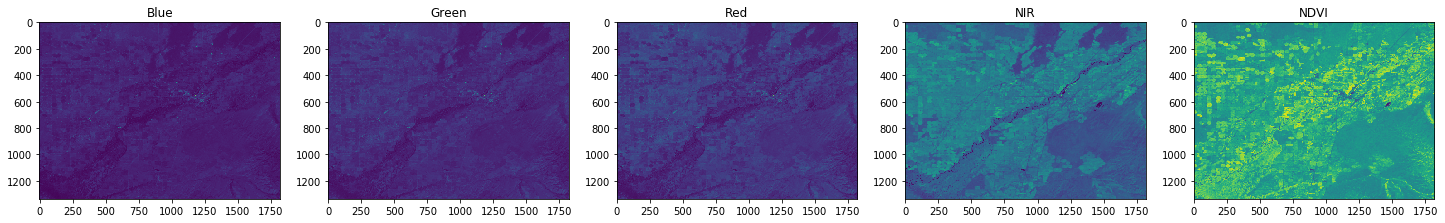

In [265]:
display_channels(data_x, data_x.shape[2], titles=['Blue', 'Green', 'Red', 'NIR', 'NDVI'])

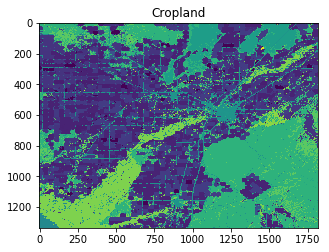

In [266]:
display_channels(data_y, data_y.shape[2], titles=['Cropland'])

In [267]:
# We replace the class labels
new_data_y = np.copy(data_y[:,:,0])
new_data_y = replace_values(new_data_y, class_labels_3, 3.)
new_data_y = replace_values(new_data_y, class_labels_2, 2.)
new_data_y = replace_values(new_data_y, class_labels_1, 1.)
new_data_y = replace_values(new_data_y, class_labels_0, 0.)

In [268]:
# Convert 1-dimensional class arrays to 3-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, 4)

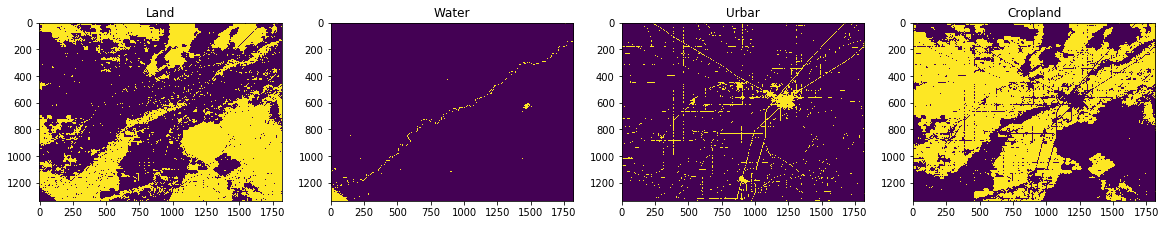

In [269]:
display_channels(new_data_y, new_data_y.shape[2], titles=['Land', 'Water', 'Urbar', 'Cropland'])

In [270]:
# Normalize
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data[:,:,i].max()
        mn = data[:,:,i].min()
        
        data[:,:,i] = (data[:,:,i]-mn)/(mx-mn)
    return data
data_x_norm = normalize_data(data_x)

In [271]:
size_x, new_size_x = reshape_data(data_x_norm)

x_input = data_x_norm.reshape(new_size_x)

In [272]:
y_output = model.predict(x_input[:,3:], batch_size=batch_size, verbose=0)

In [273]:
data_y_output = y_output.reshape((size_x[0], size_x[1],4))

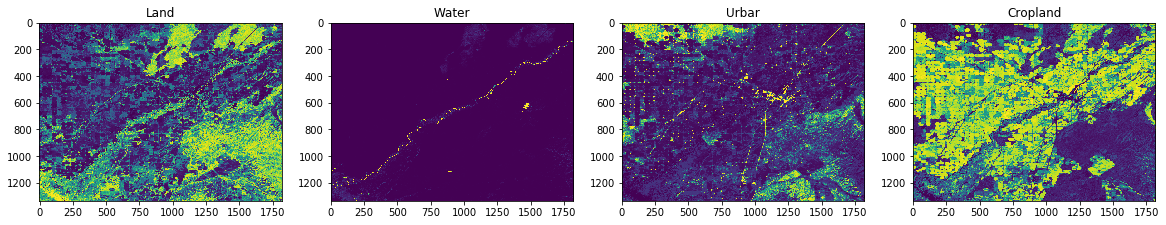

In [274]:
display_channels(data_y_output, data_y_output.shape[2], titles=['Land', 'Water', 'Urbar', 'Cropland'])

In [275]:
# Binarize the output
def max_pixels(x):
    x_new = x*0
    max_val = np.amax(x, axis=2)
    size = x.shape
    for i in range(size[-1]):
        ima = x[:,:,i]*0
        ima[np.where(x[:,:,i] == max_val)] = 1
        x_new[:,:,i]= ima

    return x_new

In [276]:
data_y_output_max = max_pixels(data_y_output)

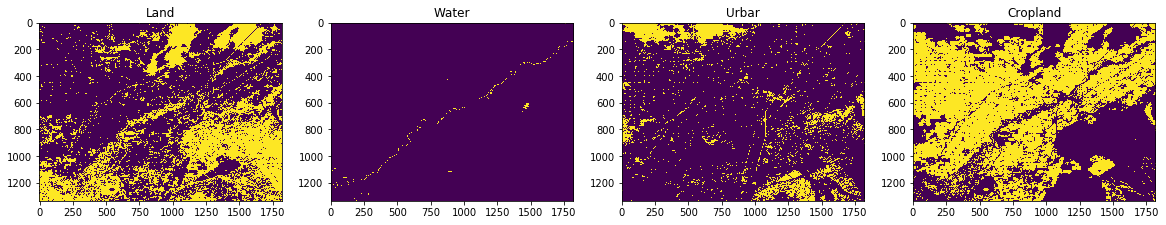

In [277]:
display_channels(data_y_output_max, data_y_output.shape[2], titles=['Land', 'Water', 'Urbar', 'Cropland'])

In [253]:
from Landsat_dataset import landsat_datasets

In [254]:
point = [19.7368, -17.9489]
landsat = landsat_datasets(point = point, buffer = 12000 , startDate = '2014', stopDate = '2017', scale = 30)
dataset_x = landsat.read_datasets()

url:  https://earthengine.googleapis.com/api/download?docid=d93fc06c0334e3bc701534bced2db8d1&token=7a57e980954f0c9bef52a529aaba5fcd
Download complete!
Error: ./cdl_data - No such file or directory.


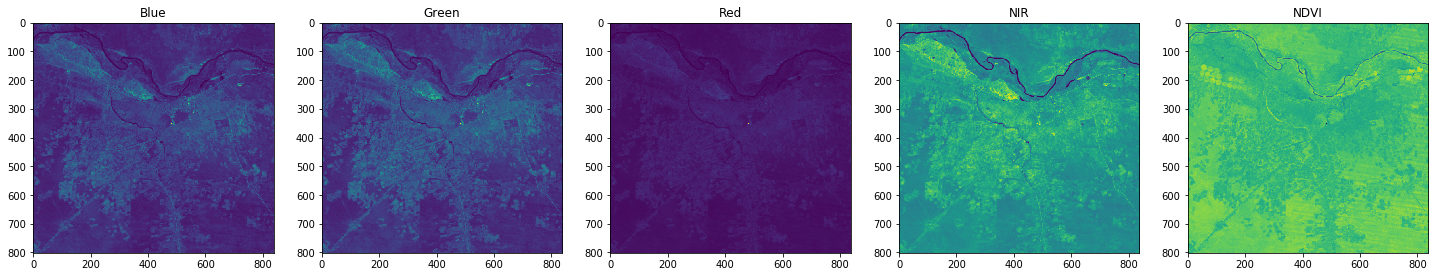

In [255]:
display_channels(dataset_x, dataset_x.shape[2], titles=['Blue', 'Green', 'Red', 'NIR', 'NDVI'])

In [256]:
#Normalize
dataset_x_norm = normalize_data(dataset_x)

In [257]:
size_x, new_size_x = reshape_data(dataset_x_norm)

x_input = dataset_x_norm.reshape(new_size_x)

In [258]:
y_output = model.predict(x_input[:,3:], batch_size=batch_size, verbose=0)

In [259]:
data_y_output = y_output.reshape((size_x[0], size_x[1],4))

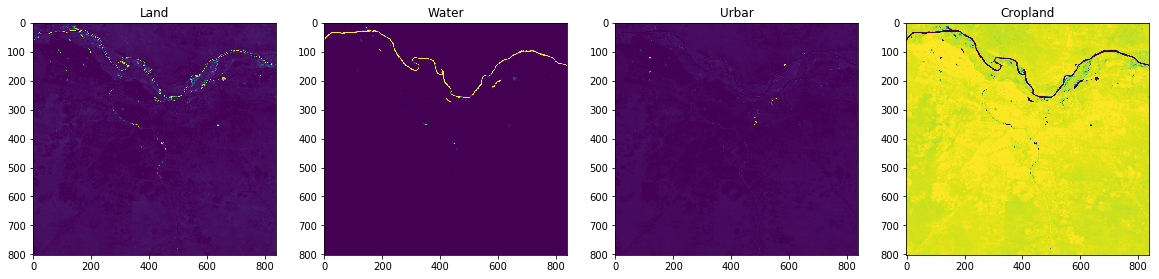

In [260]:
display_channels(data_y_output, data_y_output.shape[2], titles=['Land', 'Water', 'Urbar', 'Cropland'])

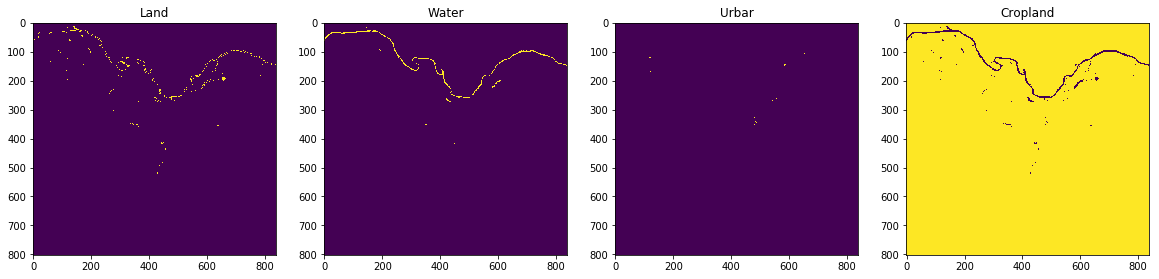

In [261]:
data_y_output_max = max_pixels(data_y_output)
display_channels(data_y_output_max, data_y_output.shape[2], titles=['Land', 'Water', 'Urbar', 'Cropland'])